In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Problem Description

This project uses deep learning to classify tweets based on if they are about real disasters. This is a Kaggle competition at https://www.kaggle.com/competitions/nlp-getting-started. The focus is on testing out recurrent neural networks (RNNs) to perform this classification.

We will utilize natural language processing (NLP), a field of computer science that focuses on how computing technology can work with "natural language," language that occurs naturally with humans. In this scenario, we are looking at a subset of tweets that are written in English and are illustrative of how people communicate in a natural manner with the English language. The "natural" aspect speaks to how people actually use the language rather than just focusing on the formal ways in which people are supposed to use the language. The RNNs we will test out require numbers as inputs, so our use of NLP will include converting written text into numeric representation as well as capturing relationships and context within the language. 

We will need the context abilities of RNNs since the use of disaster-related words on their own may not indicate an actual disaster. For example, someone may tweet "This is a disaster," using the literal word "disaster" but referring metaphorically to a situation that is not a disaster that, for instance, a disaster relief group needs to respond to.

After building the models, the competition asks us to submit files with target labels for the test set to evaluate and compare with other submissions based on F1 score.

## Data Description & Initial Preprocessing

In [35]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_sample_submission = pd.read_csv('./data/sample_submission.csv')
df_sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [36]:
print(f'The training set has {df_train.shape[0]:,} rows and {df_train.shape[1]} columns')
print(f'The test set has {df_test.shape[0]:,} rows and {df_test.shape[1]} columns')
df_train.head()

The training set has 7,613 rows and 5 columns
The test set has 3,263 rows and 4 columns


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset has three features we will be working with:
- id: unique identifier that we will drop
- keyword: a keyword from the tweet and can be null
- location: location from where the tweet was send and can be null
- text: the body of a tweet
- target: 1 if the tweet is an actual disaster and 0 if it is not

First we check the overall size and shape of the data we are working with. The sample submission file in the end will need one row per `id` and `target` label, so nothing fancy. We also want to see if there are duplicates in the training set. The initial thought is that we will want to remove any rows that are duplicated across all columns except for `id` so that the modeling is not favoring identical rows that show up more than once.

Note that the default for the `keep` param for `duplicated()` is first, meaning that the first instance of a duplicated row is flagged as valid and the remaining duplicated rows show up here. We want to keep one of each duplicated row, so the default for `keep` is good.

In [37]:
# Check if any rows are duplicated across all features
print(f'Train: there are {df_train[df_train.duplicated()].shape[0]} rows duplicated across all features, including the id feature')
print(f'Test:  there are {df_test[df_test.duplicated()].shape[0]} rows duplicated across all features, including the id feature')
print()

# Check if any ids are duplicated
print(f'Train: there are {df_train[df_train.duplicated(subset='id')].shape[0]} duplicated ids')
print(f'Test:  there are {df_test[df_test.duplicated(subset='id')].shape[0]} duplicated ids')
print()

# Check if any rows are duplicated just in the text feature
print(f'Train: there are {df_train[df_train.duplicated(subset='text')].shape[0]} rows duplicated across the text feature')
print(f'Test:  there are {df_test[df_test.duplicated(subset='text')].shape[0]} rows duplicated across the text feature')
print()

# Check if any rows are duplicated across the keyword, location, and text features. 
# This is the duplication we are looking to address.
print(f'Train: there are '
    f'{df_train[df_train.duplicated(
        subset=[
            'keyword'
            , 'location'
            , 'text'
        ]
        # , keep=False # Returns 97 rows in total when this is uncommented
    )].shape[0]} '
  f'rows duplicated across the keyword, location, text features'
)
print(f'Test:  there are '
    f'{df_test[df_test.duplicated(
        subset=[
            'keyword'
            , 'location'
            , 'text'
        ]
        # , keep=False # Returns 97 rows in total when this is uncommented
    )].shape[0]} '
      f'rows duplicated across the keyword, location, text features'
)
print()

# Drop rows that are duplicated across the keyword, location, and text features
df_train.drop_duplicates(
    subset=[
        'keyword'
        , 'location'
        , 'text'
    ], inplace=True
)
df_test.drop_duplicates(
    subset=[
        'keyword'
        , 'location'
        , 'text'
    ], inplace=True
)

print(f'Train: we end up with {df_train.shape[0]:,} rows remaining after dropping duplicates')
print(f'Test:  we end up with {df_test.shape[0]:,} rows remaining after dropping duplicates')

Train: there are 0 rows duplicated across all features, including the id feature
Test:  there are 0 rows duplicated across all features, including the id feature

Train: there are 0 duplicated ids
Test:  there are 0 duplicated ids

Train: there are 110 rows duplicated across the text feature
Test:  there are 20 rows duplicated across the text feature

Train: there are 61 rows duplicated across the keyword, location, text features
Test:  there are 11 rows duplicated across the keyword, location, text features

Train: we end up with 7,552 rows remaining after dropping duplicates
Test:  we end up with 3,252 rows remaining after dropping duplicates


We see 61 rows that are duplicated across all features except the primary key "id" feature. This is 0.8% out of the 7,613 total rows, so we can drop them without losing too much data.

Next we need to clean up bad characters. We see some characters that do not look like they were encoded correctly in the original CSV. To simplify preprocessing at this stage, we are going to drop any rows that have non-ASCII characters. This is too broad of a net to cast for characters to address, but it is an okay starting place. In future iterations, this is something to return to with a more complicated strategy for cleaning up these characters, in particular finding a way to determine if there are valid non-ASCII characters in terms of meaning that we should keep for modeling.

In [38]:
# Example row with both bad characters and valid-but-not-ASCII characters.
df_train[df_train['id'] == 3373]

,id,keyword,location,text,target
2345,3373,demolition,NaN,General News Û¢åÊ'Demolition of houses on wat...,0


In [39]:
# Check for non-ASCII chars in keyword feature -- note that we return 0 for this
print(f'Train: rows where keyword feature has non-ASCII characters: {df_train[df_train['keyword'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}')
print(f'Test:  rows where keyword feature has non-ASCII characters: {df_test[df_test['keyword'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}')
print()

# Check for non-ASCII chars in location feature
print(f'Train: rows where location feature has non-ASCII characters: {df_train[df_train['location'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}')
print(f'Test:  rows where location feature has non-ASCII characters: {df_test[df_test['location'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}')
print()

# Check for non-ASCII chars in text feature
print(f'Train: rows where text feature has non-ASCII characters: {df_train[df_train['text'].str.contains(r'[^\x00-\x7F]')].shape[0]}')
print(f'Test:  rows where text feature has non-ASCII characters: {df_test[df_test['text'].str.contains(r'[^\x00-\x7F]')].shape[0]}')
print()

# Check for non-ASCII chars in location or feature
print(f'Train: rows where location or text feature has non-ASCII characters: '
    f'{df_train[df_train['text'].str.contains(r'[^\x00-\x7F]') | df_train['location'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}'
)
print(f'Test:  rows where location or text feature has non-ASCII characters: '
      f'{df_test[df_test['text'].str.contains(r'[^\x00-\x7F]') | df_test['location'].str.contains(r'[^\x00-\x7F]', na=False)].shape[0]}'
)
print()

# Drop rows that have non-ASCII characters in location or text features
df_train.drop(
    df_train[df_train['text'].str.contains(r'[^\x00-\x7F]') | df_train['location'].str.contains(r'[^\x00-\x7F]')].index
    , inplace=True
)
df_test.drop(
    df_test[df_test['text'].str.contains(r'[^\x00-\x7F]') | df_test['location'].str.contains(r'[^\x00-\x7F]')].index
    , inplace=True
)

print(f'Train: we end up with {df_train.shape[0]:,} rows remaining after dropping rows with non-ASCII characters in location or text feature')
print(f'Test:  we end up with {df_test.shape[0]:,} rows remaining after dropping rows with non-ASCII characters in location or text feature')
print()


Train: rows where keyword feature has non-ASCII characters: 0
Test:  rows where keyword feature has non-ASCII characters: 0

Train: rows where location feature has non-ASCII characters: 105
Test:  rows where location feature has non-ASCII characters: 35

Train: rows where text feature has non-ASCII characters: 682
Test:  rows where text feature has non-ASCII characters: 328

Train: rows where location or text feature has non-ASCII characters: 779
Test:  rows where location or text feature has non-ASCII characters: 359

Train: we end up with 6,773 rows remaining after dropping rows with non-ASCII characters in location or text feature
Test:  we end up with 2,893 rows remaining after dropping rows with non-ASCII characters in location or text feature



The final cleanup step before jumping into EDA and further preprocessing is to handle missing values since the models in a bit do not play nice with nulls.

As we see in the next code block, there are 58 rows with null keyword values, and there are 2,278 rows with null locations. 58 is probably small enough for us to drop at this point, but 2,278 is too many to lose. Unfortunately, the missing keywords do not overlap with missing locations.

We will drop the rows with NAs for the keyword feature, and we will manually scan through the rows with missing values for the location feature to see if any patterns pop out. If we are able to find an informed strategy, we might be able to leverage something smarter for imputing values.

In [41]:
print('train:')
print(df_train.isna().sum())
print()
print('test:')
print(df_test.isna().sum())
print()
df_train.dropna(subset='keyword').isna().sum()
df_test.dropna(subset='keyword').isna().sum()

df_train.dropna(
    subset='keyword'
    , inplace=True
)
df_test.dropna(
    subset='keyword'
    , inplace=True
)

train:
id             0
keyword       58
location    2278
text           0
target         0
dtype: int64

test:
id            0
keyword      24
location    993
text          0
dtype: int64



In [43]:
df_train[df_train.isna().any(axis=1)].sample(100)

,id,keyword,location,text,target,is_location_imputed,location_imputed
6414,9172,suicide%20bomber,NaN,@Abu_Baraa1 Suicide bomber targets Saudi mosqu...,1,1,nope
4598,6540,injury,NaN,JOBOOZOSO: USAT usatoday_nfl Michael Floyd's h...,0,1,nope
1073,1549,bomb,NaN,@smallforestelf Umm because a gun stopped the ...,1,1,nope
4349,6175,hijack,NaN,@RickyBonesSXM fuck u2 specially there new Shi...,0,1,nope
989,1436,body%20bagging,NaN,@MeekMill is w(rec)k league ball @Drake is Oly...,0,1,nope
...,...,...,...,...,...,...,...
2537,3641,desolation,NaN,#4: The Hobbit: The Desolation of Smaug (Bilin...,0,1,nope
6467,9251,sunk,NaN,descended or sunk however it may be to the sha...,0,1,nope
5542,7907,radiation%20emergency,NaN,Who Else Wants Documents Radiation Emergency P...,0,1,nope
1141,1645,bombing,NaN,@NBCNews Yea bombing #pearlharbor not so good ...,1,1,nope


Unfortunately, there does not appear to be a pattern in how locations are missing. I want to keep location in the modeling, so we will impute "nope" for rows that are missing location. We will also add a boolean flag indicating if we imputed location so the model can have that as an extra input.

In [42]:
# Note that this cell is not idempotent
df_train['is_location_imputed'] = df_train['location'].isna().astype(int)
df_train['location_imputed'] = df_train['location'].fillna('nope')

df_test['is_location_imputed'] = df_test['location'].isna().astype(int)
df_test['location_imputed'] = df_test['location'].fillna('nope')

### Exploratory Data Analysis (EDA)

We will start EDA by looking at what we are working with in the keyword and location features. The next code block shows that we have the same keywords in the train and test sets. The locations are a bit of a mess. We will look at those in a minute.

In [ ]:
def train_test_diffs(s1, s2):
    diff1 = set(s1).difference(set(s2))
    diff2 = set(s2).difference(set(s1))

    return diff1, diff2


In [48]:

    
    
print(f'Train: number of unique keywords: {df_train['keyword'].nunique(dropna=False)}')
print(f'Test: number of unique keywords: {df_test['keyword'].nunique(dropna=False)}')
print(f'Keywords in one dataset and not the other for (train, test): {train_test_diffs(df_train['keyword'], df_test['keyword'])}')

Train: number of unique keywords: 221
Test: number of unique keywords: 221
Keywords in one dataset and not the other for (train, test): (set(), set())

Train: number of unique locations: 3034
Test: number of unique locations: 1444


In [65]:
df_train['keyword'].value_counts()

keyword
windstorm                39
deluge                   39
harm                     39
damage                   39
wrecked                  38
                         ..
tragedy                  18
epicentre                12
inundation                9
threat                    7
radiation%20emergency     7
Name: count, Length: 221, dtype: int64

In [68]:
# Note that this is not idempotent
print(f'Train: number of rows with URI percent encoding other than %20: {df_train[df_train['keyword'].str.contains('%') & ~df_train['keyword'].str.contains('%20')].shape[0]}')
print(f'Test: number of rows with URI percent encoding other than %20: {df_test[df_test['keyword'].str.contains('%') & ~df_test['keyword'].str.contains('%20')].shape[0]}')

df_train['keyword_clean'] = df_train['keyword'].str.replace('%20', ' ')
df_test['keyword_clean'] = df_test['keyword'].str.replace('%20', ' ')

Train: number of rows with URI percent encoding other than %20: 0
Test: number of rows with URI percent encoding other than %20: 0


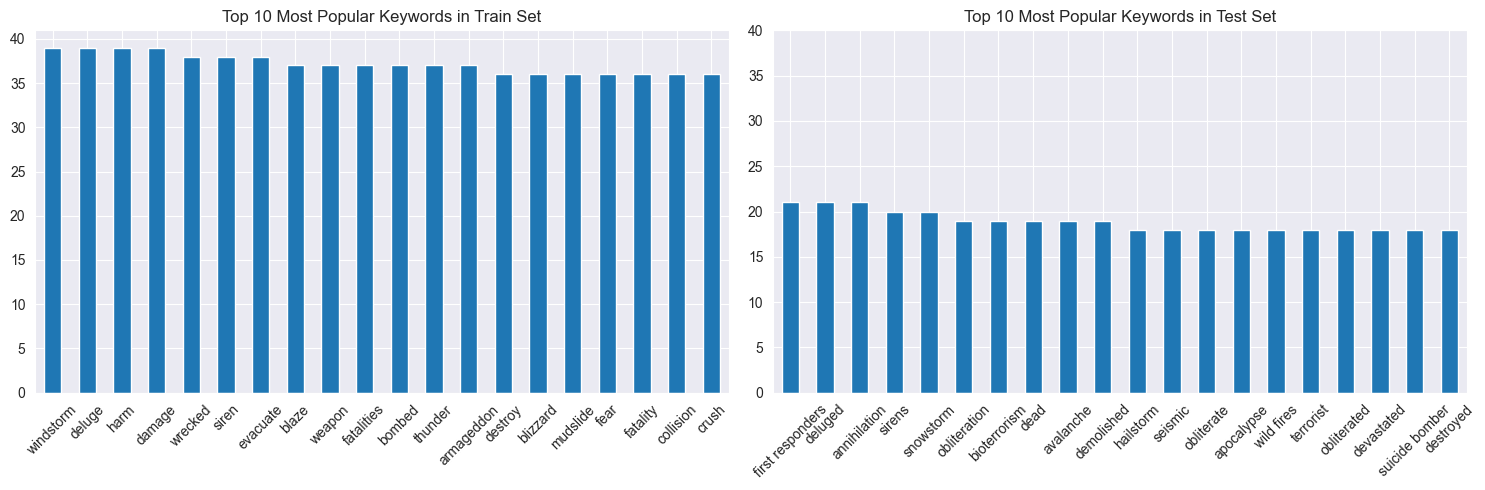

In [101]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

df_train['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[0]
    , rot=45
);
axes[0].set_title('Top 10 Most Popular Keywords in Train Set')
axes[0].set_xlabel(None)


df_test['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[1]
    , rot=45
);
axes[1].set_title('Top 10 Most Popular Keywords in Test Set')
# Manually set y-axis limits for second plot for relative comparison
axes[1].set_ylim([0, 40])
axes[1].set_xlabel(None)

plt.tight_layout()

The only thing that stands out with the keywords is that they still have uniform resource identifier (URI) percent encoding for spaces as %20s. That is an easy find-and-replace.

We then check out the 10 most common keywords in the train and test sets, mostly looking to see if the same keywords show up in each. Interestingly, they do not overlap. I was expecting them to. This could be chance, or it could be that we have a curated test set where the common values purposely do not match. Either way, this will not change our approach to modeling later.

Next, we will figure out what to do with the location feature.

In [112]:
print(f'Train: number of unique locations: {df_train['location'].nunique(dropna=False):,}')
print(f'Test: number of unique locations: {df_test['location'].nunique(dropna=False):,}')
print()

in_train_not_test, in_test_not_train = train_test_diffs(df_train['location'], df_test['location'])
print(f'Number of unique locations in train but not test: {len(in_train_not_test):,}')
print(f'Number of unique locations in test but not train: {len(in_test_not_train):,}')

# Just for kicks
df_train['location'].value_counts().sample(100, random_state=8675309)
# df_test['location'].value_counts().sample(100, random_state=8675309)

Train: number of unique locations: 3,034
Test: number of unique locations: 1,444

Number of unique locations in train but not test: 2,653
Number of unique locations in test but not train: 1,063


location
Garrett                           1
Torry Alvarez love forever ? ?    1
Knoxville, TN                     1
Fakefams                          1
Multinational *****               1
                                 ..
Bandar Lampung, Indonesia         1
Colorado/WorldWide                1
Vermont, USA                      1
DFW, Texas                        1
mind ya business                  1
Name: count, Length: 100, dtype: int64

This feature is all over the place. There are about 2,500 locations in the train set that are not in the test set, and there are about 1,063 in reverse. The sample of 100 locations from the training set have some valid locations, some that need a bit of interpretation or judgment to parse out, and some that are useless. The main issue is that I do not see a way to programmatically clean these up, and, since there are thousands that we would need to go through by hand, manual clean up is not the most important use of time for this iteration. We will leave the location feature out of modeling for this iteration of the project, though this is an area to return to in future iterations to try and capture more info.

Next we check out the text feature.

In [50]:
tweet_num_chars_train = df_train['text'].str.len()
tweet_num_words_test = df_train['text'].str.split().str.len()
print('Character counts:')
print(tweet_num_chars_train.describe())
print()
print('Word counts:')
print(tweet_num_words_test.describe())

Character counts:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

Word counts:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64
